Comparing the DG method with the Trefftz-DG method on the anisotropic mesh in 1+1 dimensions. In this case, both, Trefftz and L2 space are constructed from a space for the second order system. Since the Hessian for the L2 space is needed the following lines have to be added in the constructor for the l2 space in l2hofespace.cpp

    switch (ma->GetDimension())
    {
    case 1:
        additional_evaluators.Set ("hesse", make_shared<T_DifferentialOperator<DiffOpHesse<1>>> ());
        break;
    case 2:
        additional_evaluators.Set ("hesse", make_shared<T_DifferentialOperator<DiffOpHesse<2>>> ());
        break;
    case 3:
        additional_evaluators.Set ("hesse", make_shared<T_DifferentialOperator<DiffOpHesse<3>>> ());
        additional_evaluators.Set ("hesseboundary", make_shared<T_DifferentialOperator<DiffOpHesseBoundary<3>>> ());
        break;
    default:
        ;
    }

## Define Functions

In [1]:
import sys
sys.path.append("..")
sys.path.append("../cartsolve/")
from ngsolve import *
SetHeapSize(100*1000*1000)

from trefftzngs import *
from DGeq import *
from prodmesh import *
from math import pi

In [2]:
def SolveWaveeq(fes,fullsys):
    [a,f] = DGeqsys(fes,truesol,v0,sig0,c,v0,fullsys)
    [gfu, cond] = DGsolve(fes,a,f)
    
    L2error = sqrt(Integrate((truesol - gfu)*(truesol - gfu), mesh))
    
    gradtruesol = CoefficientFunction((-sig0,v0))
    sH1error = sqrt(Integrate((gradtruesol - grad(gfu))*(gradtruesol - grad(gfu)), mesh))
    
    dof=fes.ndof/(N*t_steps)
    
    return [dof,cond,L2error,sH1error]

## Run comparison

In [3]:
N = 4
c = 1
t_steps = c*N
order = 12
k = 1
D = 2

truesol =  sin( k*(c*y + x) )#exp(-pow(c*x+y,2)))#
v0 = c*k*cos(k*(c*y+x))#grad(U0)[1]
sig0 = -k*cos(k*(c*y+x))#-grad(U0)[0]

c=1
truesol = cos(pi*x)*sin(pi*y)/pi
v0 = cos(pi*x)*cos(pi*y)
sig0 = sin(pi*x)*sin(pi*y)

mesh = CartSquare(N,t_steps)

solution = []

for ordr in range(2,order):
    print("run order: " + str(ordr))

    btype = 0
    fes = L2(mesh, order=ordr, dgjumps=True)
    [dof,cond,L2error,sH1error] = SolveWaveeq(fes, True)
    solution.append([btype, ordr, dof,cond,L2error,sH1error])
    print("btype: " + 'L2' + " dof: " + str(dof) + " cond: " + str(cond) + " L2error: " + str(L2error) + " H1error: "+ str(sH1error))

    btype = 1
    fes = FESpace("trefftzfespace", mesh, order = ordr, wavespeed = c, dgjumps=True, basistype = 0)
    [dof,cond,L2error,sH1error] = SolveWaveeq(fes, False)
    solution.append([btype,ordr,dof,cond,L2error,sH1error])
    print("btype: " + 'Trefftz' + " dof: " + str(dof) + " cond: " + str(cond) + " L2error: " + str(L2error) + " H1error: "+ str(sH1error))

run order: 2
btype: L2 dof: 9.0 cond: 14410.693527362431 L2error: 0.0020753823213945457 H1error: 0.0292628542072255
btype: Trefftz dof: 5.0 cond: 2113.983106530009 L2error: 0.008640960419615366 H1error: 0.06843826912303842
run order: 3
btype: L2 dof: 16.0 cond: 47311.78902900147 L2error: 7.259766099943434e-05 H1error: 0.001403598011287895
btype: Trefftz dof: 7.0 cond: 5507.611832645976 L2error: 0.0003335895047952082 H1error: 0.0063068814295893245
run order: 4
btype: L2 dof: 25.0 cond: 135139.4158008909 L2error: 1.8865725586032406e-06 H1error: 9.085422408316474e-05
btype: Trefftz dof: 9.0 cond: 12442.803615304487 L2error: 2.6812046102029133e-05 H1error: 0.0006416284496931196
run order: 5
btype: L2 dof: 36.0 cond: 313969.10998087004 L2error: 6.263523452867514e-08 H1error: 3.370101420916305e-06
btype: Trefftz dof: 11.0 cond: 30054.948406389412 L2error: 2.05274548558822e-06 H1error: 6.83444425916176e-05
run order: 6
btype: L2 dof: 49.0 cond: 660874.1044051667 L2error: 1.252279998534008e-09

## Draw Comparison

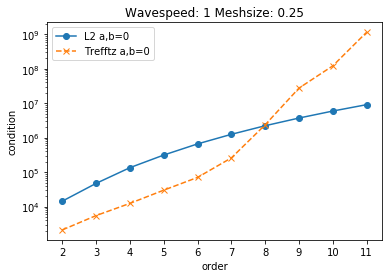

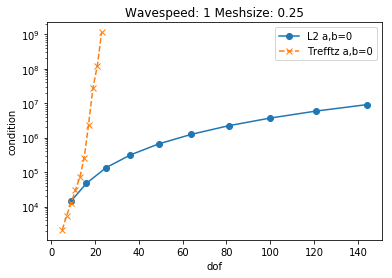

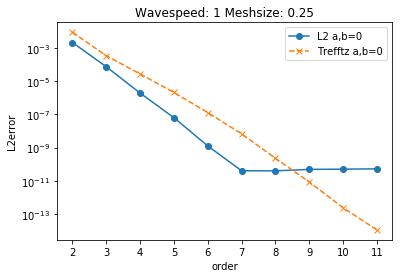

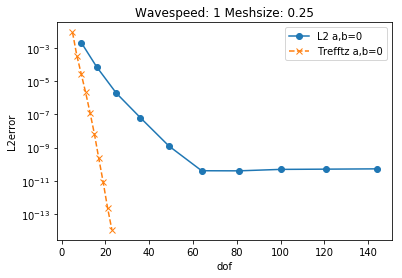

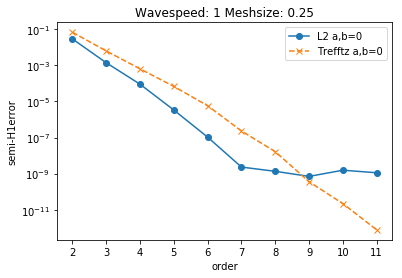

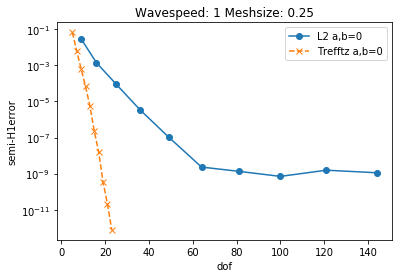

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

label = ['','order','dof','condition', 'L2error', 'semi-H1error']
sol = np.array(solution)

for yaxis in [3,4,5]:
    for xaxis in [1,2]:
        fig = plt.figure()
        ax = fig.gca()
        plt.semilogy(sol[sol[:,0]==0,xaxis], sol[sol[:,0]==0,yaxis], '-o', label="L2 a,b=0")
        plt.semilogy(sol[sol[:,0]==1,xaxis], sol[sol[:,0]==1,yaxis], '--x', label="Trefftz a,b=0")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.title('Wavespeed: ' + str(c) + " Meshsize: " + str(1/N))
        plt.legend()
        plt.ylabel(label[yaxis])
        plt.xlabel(label[xaxis])
        plt.savefig("../results/pvtv3_"+label[yaxis]+label[xaxis]+".eps")
        plt.show()